In [1]:
import os

import librosa
import numpy as np
import random
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torchaudio
from torchaudio import transforms

import torch.nn.functional as F
from torch.nn import init

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Print the version of pytorch
print(torch.__version__)

2.2.1+cu121


In [3]:
p01_df = pd.read_csv('data/p01_df.csv')

In [5]:
durations = []

for i in range(len(p01_df)):
    signal, sample_rate = torchaudio.load('data/denoised_wav/' + p01_df['Filename'].iloc[i])
    durations.append(signal.size(1) / sample_rate)
    
# Find the maximum length in milliseconds of the audio files
max_length = max(durations)

print("The maximum length of the audio files is: ", max_length, "seconds")

The maximum length of the audio files is:  14.057 seconds


In [6]:
signal.shape[0]

1

In [7]:
# Assuming p01_df['Filename'] contains the filenames of the audio files
audio_dir = 'data/denoised_wav/'  # Replace with the path to your audio directory

# Initialize counters for mono and stereo files
mono_count = 0
stereo_count = 0

# Iterate over each file in the DataFrame
for filename in p01_df['Filename']:
    filepath = os.path.join(audio_dir, filename)

    # Load the audio file
    signal, sample_rate = torchaudio.load(filepath)

    # Check the number of channels
    if signal.shape[0] == 1:
        mono_count += 1
    elif signal.shape[0] == 2:
        stereo_count += 1

# Output the results
print(f"Number of mono audio files: {mono_count}")
print(f"Number of stereo audio files: {stereo_count}")

Number of mono audio files: 1708
Number of stereo audio files: 0


In [8]:
def convert_to_mono(signal):
    if signal.shape[0] == 2:  # If the signal has 2 channels (stereo)
        signal = signal.mean(dim=0, keepdim=True)  # Convert to mono by averaging the channels
    return signal

In [9]:
# Find the maximum length in samples
max_length_samples = int(max_length * sample_rate)

In [10]:
# Instead, define a function to pad the signal to the maximum length

def pad_signal(signal, max_length_samples):
    if signal.shape[1] < max_length_samples:
        pad_begin_len = random.randint(0, max_length_samples - signal.shape[1]) # Begin padding length can be anything between 0 and the difference between the max length and the signal length
        pad_end_len = max_length_samples - signal.shape[1] - pad_begin_len  # End padding length is the difference between the max length and the sum of the signal length and the begin padding length

        # Pad with zeros
        pad_begin = torch.zeros(signal.shape[0], pad_begin_len)
        pad_end = torch.zeros(signal.shape[0], pad_end_len)

        signal = torch.cat((pad_begin, signal, pad_end), 1)
        
    return signal

In [11]:
# Define a function to shift the signal in time by a random amount between -0.5 and 0.5 seconds

def shift_signal(signal, sample_rate):
    shift_amount = random.uniform(-0.5, 0.5)
    shift_samples = int(shift_amount * sample_rate) # Convert the shift amount to samples
    
    if shift_samples > 0:
        # Shift the signal to the right
        signal = torch.cat((torch.zeros(signal.shape[0], shift_samples), signal[:, :-shift_samples]), 1)
    else:
        # Shift the signal to the left
        signal = torch.cat((signal[:, -shift_samples:], torch.zeros(signal.shape[0], -shift_samples)), 1)
        
    return signal

In [12]:
# Define a function to generate mel spectrograms from the audio files

def generate_mel_spectrogram(signal, sample_rate, n_mels=128, fmin=0, fmax=None, n_fft=2048):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels, f_min=fmin, f_max=fmax, n_fft=n_fft)(signal)
    mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    
    return mel_spectrogram

In [13]:
# Define a function to do time and frequency masking on the mel spectrogram

def mask_mel_spectrogram(mel_spectrogram, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    n_mel_channels = mel_spectrogram.shape[1] # Number of mel channels
    n_mel_frames = mel_spectrogram.shape[2] # Number of mel frames
    
    max_mask_size_freq = int(max_mask_pct * n_mel_channels) # Maximum size of the frequency mask
    max_mask_size_time = int(max_mask_pct * n_mel_frames) # Maximum size of the time mask
    
    for _ in range(n_freq_masks):
        mask_size_freq = random.randint(0, max_mask_size_freq) # Random size of the frequency mask
        mask_start_freq = random.randint(0, n_mel_channels - mask_size_freq) # Random start of the frequency mask
        mel_spectrogram[:, mask_start_freq:mask_start_freq + mask_size_freq, :] = 0 
        
    for _ in range(n_time_masks):
        mask_size_time = random.randint(0, max_mask_size_time) # Random size of the time mask
        mask_start_time = random.randint(0, n_mel_frames - mask_size_time) # Random start of the time mask
        mel_spectrogram[:, :, mask_start_time:mask_start_time + mask_size_time] = 0
        
    return mel_spectrogram

In [14]:
# Define a function to augment the audio files

def augment_audio_files(audio_files, max_length_samples, sample_rate, n_mels=128, fmin=0, fmax=None, n_fft=2048, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    mel_spectrograms = []
    augmented_audio_files = [] # To store the augmented audio files
    
    for i in range(len(audio_files)):
        signal = torch.tensor(audio_files[i])
        signal = convert_to_mono(signal)
        
        # Check if conversion to mono was successful
        if signal.shape[0] != 1:
            print(f"Warning: Signal {i} is not mono after conversion. Shape: {signal.shape}")

        signal = pad_signal(signal, max_length_samples)
        signal = shift_signal(signal, sample_rate)
        
        augmented_audio_files.append(signal.numpy()) # Append the augmented audio file
        
        mel_spectrogram = generate_mel_spectrogram(signal, sample_rate, n_mels, fmin, fmax, n_fft)
        mel_spectrogram = mask_mel_spectrogram(mel_spectrogram, max_mask_pct, n_freq_masks, n_time_masks)
        mel_spectrograms.append(mel_spectrogram)
        
    return mel_spectrograms, augmented_audio_files

In [15]:
# Augment the audio files

audio_files = [] # List to store the audio files because apprently, csv files don't store the audio files as tensors
for i in range(len(p01_df)):
    signal, sample_rate = torchaudio.load('data/denoised_wav/' + p01_df['Filename'].iloc[i])
    audio_files.append(signal)
sample_rate = librosa.load('data/denoised_wav/' + p01_df['Filename'].iloc[0], sr=None)[1]
mel_spectrograms, augmented_signals = augment_audio_files(audio_files, max_length_samples, sample_rate)

/tmp/ipykernel_42205/2902082806.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(audio_files[i])


In [16]:
sample_rate

16000

The label of the audio file is:  selftalk


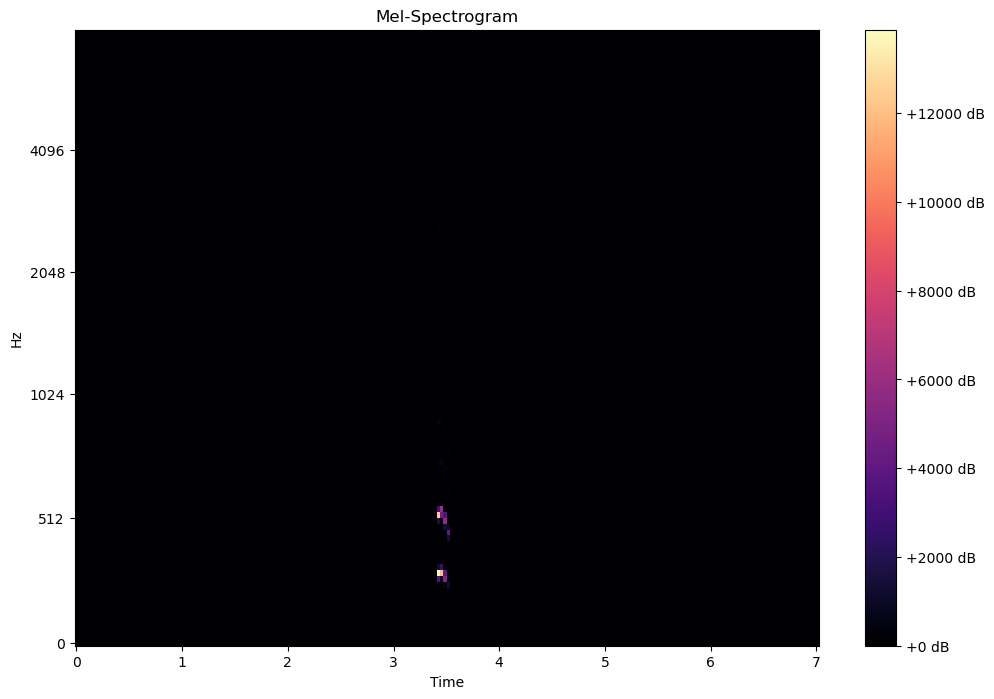

The label of the audio file is:  request


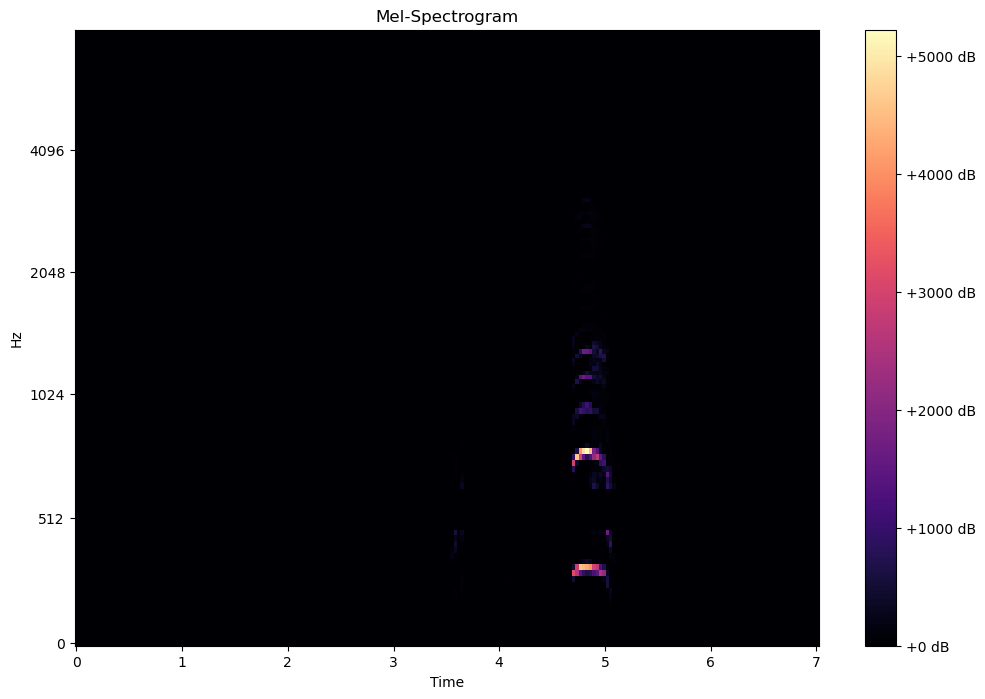

The label of the audio file is:  dysregulated


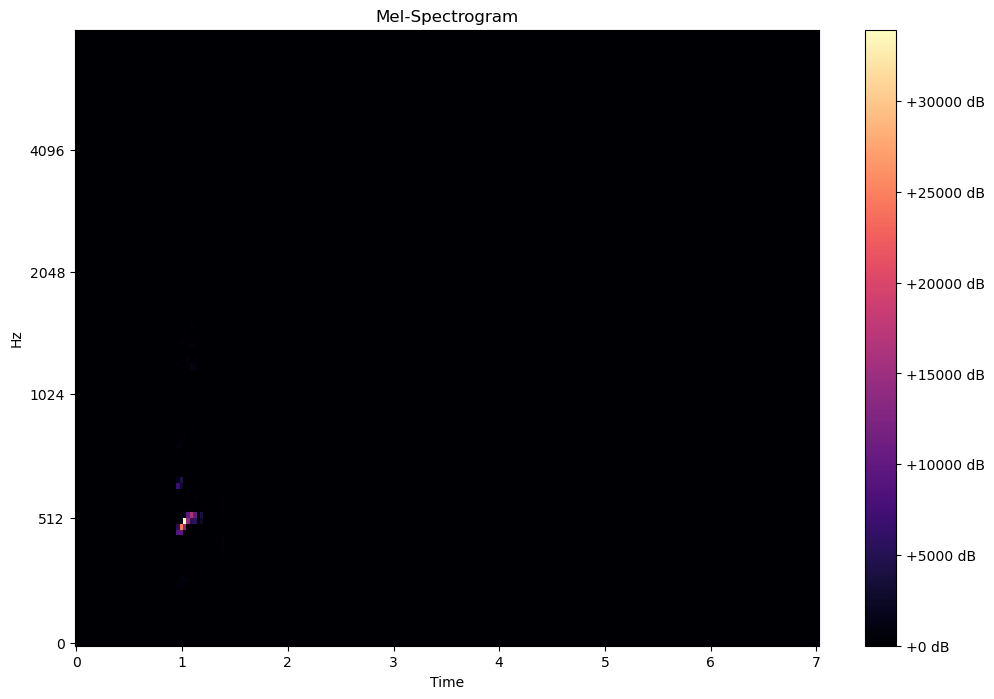

The label of the audio file is:  social


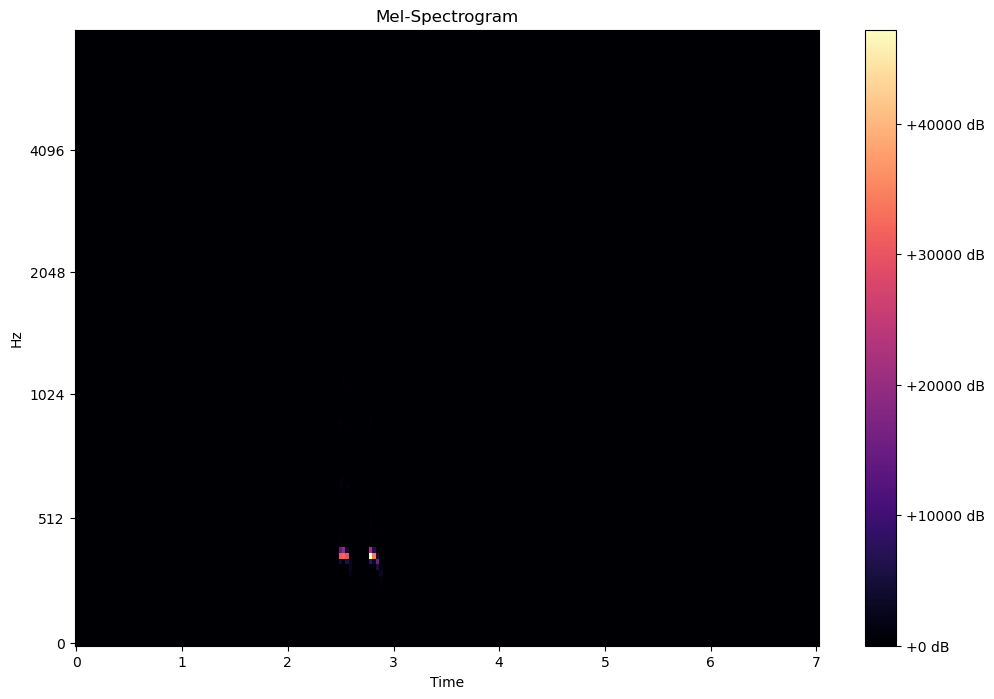

The label of the audio file is:  selftalk


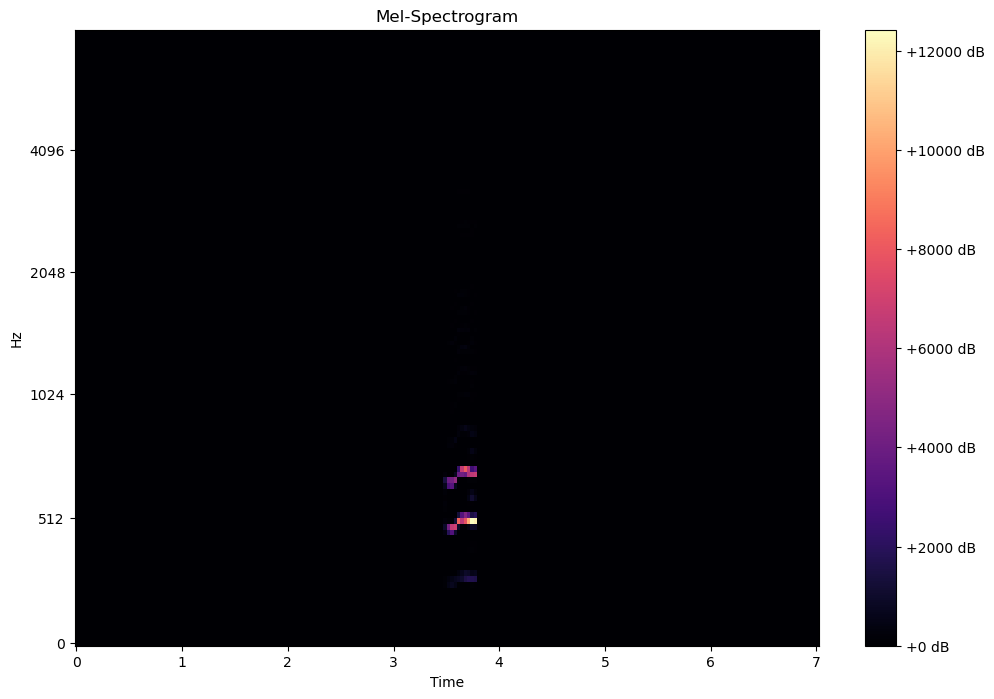

In [17]:
# Play the audio file and display the mel spectrogram for 5 random samples using librosa

ran_samps = random.sample(range(len(p01_df)), 5)

for i in ran_samps:
    print("The label of the audio file is: ", p01_df['Label'].iloc[i])
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(mel_spectrograms[i][0].numpy(), sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.show()

In [18]:
# Listen to the audio files for the 5 random samples

for i in ran_samps:
    print("The label of the audio file is: ", p01_df['Label'].iloc[i])
    display(Audio(audio_files[i], rate=sample_rate))

The label of the audio file is:  selftalk


The label of the audio file is:  request


The label of the audio file is:  dysregulated


The label of the audio file is:  social


The label of the audio file is:  selftalk


In [19]:
# Listen to the augmented audio files for the 5 random samples

for i in ran_samps:
    print("The label of the audio file is: ", p01_df['Label'].iloc[i])
    display(Audio(augmented_signals[i], rate=sample_rate))

The label of the audio file is:  selftalk


The label of the audio file is:  request


The label of the audio file is:  dysregulated


The label of the audio file is:  social


The label of the audio file is:  selftalk


In [20]:
# Create a 80:20 train and test split for the dataset for participant 1 using the augmented audio files and mel spectrograms

# Add the mel spectrograms and augmented audio files to the dataframe
p01_df['Mel Spectrogram'] = mel_spectrograms
p01_df['Augmented Audio'] = augmented_signals

# Save the dataframe to a csv file
# p01_df.to_csv('data/p01_df_augmented.csv', index=False) # Index is set to False to avoid saving the index column

# Make the train and test split for the dataset

X_train, X_test, y_train, y_test = train_test_split(p01_df[['Augmented Audio', 'Mel Spectrogram']], p01_df.drop(['Augmented Audio', 'Mel Spectrogram'], axis=1), test_size=0.2, random_state=42, shuffle=True, stratify=p01_df['Label'])
# Stratify the split based on the labels and not the one-hot encoded labels as the one-hot encoded labels are not present in the dataframe anymore and drop the augmented audio and mel spectrogram columns from the x dataframes as they are not needed

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1366, 2), (342, 2), (1366, 10), (342, 10))

In [22]:
X_test

,Augmented Audio,Mel Spectrogram
1186,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1626,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1059,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
866,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
990,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...
1677,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1707,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1194,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1693,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [23]:
y_test

,Filename,Participant,Label,Audio,delighted,dysregulated,frustrated,request,selftalk,social
1186,200329_1113_00-13-38.86--00-13-39.94.wav,P01,selftalk,[ 0.0186615 0.00944519 0.0038147 ... -0.01...,False,False,False,False,True,False
1626,200309_2035_00-05-10.63--00-05-11.91.wav,P01,delighted,[-0.00149536 -0.00054932 -0.00024414 ... -0.00...,True,False,False,False,False,False
1059,200229_2244_00-05-22.03--00-05-23.17.wav,P01,selftalk,[-0.03457642 -0.03807068 -0.04052734 ... 0.00...,False,False,False,False,True,False
866,200306_2024_00-03-20.26--00-03-20.91.wav,P01,selftalk,[ 0.01483154 0.01954651 0.02474976 ... 0.00...,False,False,False,False,True,False
990,200306_2024_00-17-31.11--00-17-31.68.wav,P01,selftalk,[ 0.11328125 0.10844421 0.1025238 ... -0.01...,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
1677,200815_2140_00-00-15.88--00-00-18.55.wav,P01,delighted,[ 0.00408936 0.0065918 0.01071167 ... -0.03...,True,False,False,False,False,False
1707,200307_1826_00-05-53.14--00-05-53.71.wav,P01,delighted,[ 0.00387573 0.0035553 0.00352478 ... -0.00...,True,False,False,False,False,False
1194,200306_2024_00-08-21.67--00-08-24.98.wav,P01,selftalk,[-0.01591492 -0.01504517 -0.01268005 ... -0.00...,False,False,False,False,True,False
1693,200529_1029_00-01-10.01--00-01-11.35.wav,P01,delighted,[-6.1035156e-04 -3.0517578e-05 9.1552734e-04 ...,True,False,False,False,False,False


In [24]:
print(y_train.dtypes)  # Check the data types of the columns in y_train
print(y_train.head())  # Display the first few rows of y_train

Filename        object
Participant     object
Label           object
Audio           object
delighted         bool
dysregulated      bool
frustrated        bool
request           bool
selftalk          bool
social            bool
dtype: object
                                        Filename Participant         Label  \
348     200124_1828_00-09-14.62--00-09-15.67.wav         P01  dysregulated   
85    200229_2156_00-08-01.665--00-08-03.284.wav         P01    frustrated   
1526    200309_2035_00-01-53.76--00-01-54.45.wav         P01     delighted   
393    200124_1828_00-01-01.464--00-01-02.72.wav         P01  dysregulated   
1080     200306_2024_00-02-28.21--00-02-29.9.wav         P01      selftalk   

                                                  Audio  delighted  \
348   [-0.05300903 -0.06085205 -0.06741333 ... -0.22...      False   
85    [-0.0071106  -0.00773621 -0.00802612 ... -0.00...      False   
1526  [-5.6457520e-03 -5.6152344e-03 -5.5236816e-03 ...       True   
393   [

In [25]:
# Define a function to get the index of the label
def get_label_index(row):
    labels = ['delighted', 'dysregulated', 'frustrated', 'request', 'selftalk', 'social']
    for idx, label in enumerate(labels):
        if row[label]:  # If the label is True, return its index
            return idx
    return -1  # If no label is True, return an invalid index (this shouldn't happen in a clean dataset)

# Apply the function to create a label index for each row
y_train['Label_Index'] = y_train.apply(get_label_index, axis=1)
y_test['Label_Index'] = y_test.apply(get_label_index, axis=1)

# Convert to tensors for PyTorch
train_labels = torch.tensor(y_train['Label_Index'].values).long()
test_labels = torch.tensor(y_test['Label_Index'].values).long()

In [26]:
def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    # Convert the mel-spectrograms to PyTorch tensors and add the channel dimension
    train_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_train['Mel Spectrogram']])
    test_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_test['Mel Spectrogram']])

    # Convert labels to single label index
    y_train['Label_Index'] = y_train.apply(get_label_index, axis=1)
    y_test['Label_Index'] = y_test.apply(get_label_index, axis=1)

    train_labels = torch.tensor(y_train['Label_Index'].values).long()
    test_labels = torch.tensor(y_test['Label_Index'].values).long()

    # Create TensorDataset
    train_dataset = torch.utils.data.TensorDataset(train_mels, train_labels)
    val_dataset = torch.utils.data.TensorDataset(test_mels, test_labels)

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [27]:
class AudioClassifier(torch.nn.Module):

    def __init__(self, n_classes, n_mels=128):
        super(AudioClassifier, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Add global average pooling

        self.fc1 = torch.nn.Linear(256, 512)  # Adjust to the reduced size after GAP
        self.fc2 = torch.nn.Linear(512, n_classes)

        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.global_avg_pool(x)  # Apply Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten the output

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x


# Define the function to train the model

def train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader, val_loader, device):
    model.to(device)

    for epoch in range(n_epochs):
        model.train() # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0

        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device) # Move the data to the device

            optimizer.zero_grad() # Zero the gradients thereby preventing them from accumulating

            y_pred = model(X) # Get the model's predictions by forward propagating the input

            loss = criterion(y_pred, y) # Calculate the loss
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update the weights

            train_loss += loss.item() # Add the loss to the running total thereby accumulating the loss
            train_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

        train_loss /= len(train_loader.dataset) # Calculate the average loss over the dataset for the epoch
        train_acc /= len(train_loader.dataset) # Calculate the average accuracy over the dataset for the epoch

        model.eval() # Set the model to evaluation mode
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad(): # Disable gradient tracking to speed up computation
            for i, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)

                y_pred = model(X) # Get the model's predictions by forward propagating the input

                loss = criterion(y_pred, y) # Calculate the loss

                val_loss += loss.item() # Add the loss to the running total thereby accumulating the loss
                val_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

            val_loss /= len(val_loader.dataset) # Calculate the average loss over the dataset for the epoch
            val_acc /= len(val_loader.dataset) # Calculate the average accuracy over the dataset for the epoch

        print("Epoch: {} | Train Loss: {:.5f} | Train Acc: {:.5f} | Val Loss: {:.5f} | Val Acc: {:.5f}".format(epoch, train_loss, train_acc, val_loss, val_acc)) # Print the epoch number, training loss, training accuracy, validation loss and validation accuracy

        scheduler.step(val_loss) # Adjust the learning rate based on the validation loss

# Define the function to test the model

def test_model(model, test_loader, device):
    model.eval() # Set the model to evaluation mode because certain layers like dropout behave differently in training and evaluation mode
    test_acc = 0.0

    with torch.no_grad(): # Disable gradient tracking to speed up computation
        for i, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X) # Get the model's predictions by forward propagating the input

            test_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

        test_acc /= len(test_loader.dataset)

    print("Test Accuracy: {:.5f}".format(test_acc))

# Define the function to create the dataloaders

# def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
#     train_dataset = torch.utils.data.TensorDataset(X_train['Mel Spectrogram'].unsqueeze(1), torch.tensor(y_train.values).long())
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     val_dataset = torch.utils.data.TensorDataset(X_test['Mel Spectrogram'].unsqueeze(1), torch.tensor(y_test.values).long())
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     return train_loader, val_loader

# def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
#     # Convert the mel-spectrograms to PyTorch tensors and add the channel dimension
#     train_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_train['Mel Spectrogram']])
#     test_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_test['Mel Spectrogram']])

#     # Convert one-hot encoded labels to class indices
#     train_labels = torch.argmax(torch.tensor(y_train.values), dim=1).long()
#     test_labels = torch.argmax(torch.tensor(y_test.values), dim=1).long()

#     # Create TensorDataset
#     train_dataset = torch.utils.data.TensorDataset(train_mels, train_labels)
#     val_dataset = torch.utils.data.TensorDataset(test_mels, test_labels)

#     # Create DataLoaders
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     return train_loader, val_loader


# Define the hyperparameters

n_classes = len(p01_df['Label'].unique())
n_epochs = 40
batch_size = 32
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the dataloaders
train_loader, val_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)

# Create the model, criterion, optimizer and scheduler

model = AudioClassifier(n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model

train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader, val_loader, device)

# Test the model

test_model(model, val_loader, device)

/tmp/ipykernel_42205/3516308735.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_train['Mel Spectrogram']])
/tmp/ipykernel_42205/3516308735.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_test['Mel Spectrogram']])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 0 | Train Loss: 0.08610 | Train Acc: 0.25622 | Val Loss: 0.05307 | Val Acc: 0.33041
Epoch: 1 | Train Loss: 0.05187 | Train Acc: 0.32211 | Val Loss: 0.05231 | Val Acc: 0.33333
Epoch: 2 | Train Loss: 0.05050 | Train Acc: 0.34700 | Val Loss: 0.05100 | Val Acc: 0.35088
Epoch: 3 | Train Loss: 0.04928 | Train Acc: 0.36750 | Val Loss: 0.04915 | Val Acc: 0.38889
Epoch: 4 | Train Loss: 0.04819 | Train Acc: 0.38214 | Val Loss: 0.04843 | Val Acc: 0.39474
Epoch: 5 | Train Loss: 0.04663 | Train Acc: 0.39898 | Val Loss: 0.05064 | Val Acc: 0.35088
Epoch: 6 | Train Loss: 0.04662 | Train Acc: 0.39531 | Val Loss: 0.04975 | Val Acc: 0.38304
Epoch: 7 | Train Loss: 0.04536 | Train Acc: 0.40703 | Val Loss: 0.04746 | Val Acc: 0.42105
Epoch: 8 | Train Loss: 0.04441 | Train Acc: 0.42313 | Val Loss: 0.04829 | Val Acc: 0.40058
Epoch: 9 | Train Loss: 0.04304 | Train Acc: 0.43192 | Val Loss: 0.04771 | Val Acc: 0.40351
Epoch: 10 | Train Loss: 0.04176 | Train Acc: 0.46999 | Val Loss: 0.05015 | Val Acc: 0.3947

In [29]:
class AudioClassifier(torch.nn.Module):

    def __init__(self, n_classes, n_mels=128):
        super(AudioClassifier, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Add global average pooling

        self.fc1 = torch.nn.Linear(256, 512)  # Adjust to the reduced size after GAP
        self.fc2 = torch.nn.Linear(512, n_classes)

        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.global_avg_pool(x)  # Apply Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten the output

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        return x


# Define the function to train the model

def train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader, val_loader, device):
    model.to(device)

    for epoch in range(n_epochs):
        model.train() # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0

        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device) # Move the data to the device

            optimizer.zero_grad() # Zero the gradients thereby preventing them from accumulating

            y_pred = model(X) # Get the model's predictions by forward propagating the input

            loss = criterion(y_pred, y) # Calculate the loss
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update the weights

            train_loss += loss.item() # Add the loss to the running total thereby accumulating the loss
            train_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

        train_loss /= len(train_loader.dataset) # Calculate the average loss over the dataset for the epoch
        train_acc /= len(train_loader.dataset) # Calculate the average accuracy over the dataset for the epoch

        model.eval() # Set the model to evaluation mode
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad(): # Disable gradient tracking to speed up computation
            for i, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)

                y_pred = model(X) # Get the model's predictions by forward propagating the input

                loss = criterion(y_pred, y) # Calculate the loss

                val_loss += loss.item() # Add the loss to the running total thereby accumulating the loss
                val_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

            val_loss /= len(val_loader.dataset) # Calculate the average loss over the dataset for the epoch
            val_acc /= len(val_loader.dataset) # Calculate the average accuracy over the dataset for the epoch

        print("Epoch: {} | Train Loss: {:.5f} | Train Acc: {:.5f} | Val Loss: {:.5f} | Val Acc: {:.5f}".format(epoch, train_loss, train_acc, val_loss, val_acc)) # Print the epoch number, training loss, training accuracy, validation loss and validation accuracy

        scheduler.step(val_loss) # Adjust the learning rate based on the validation loss

# Define the function to test the model

def test_model(model, test_loader, device):
    model.eval() # Set the model to evaluation mode because certain layers like dropout behave differently in training and evaluation mode
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient tracking to speed up computation
        for i, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X) # Get the model's predictions by forward propagating the input
            preds = y_pred.argmax(1) # Get the class indices with the highest probability
            all_preds.extend(preds.cpu().numpy()) # Append the predictions to the list
            all_labels.extend(y.cpu().numpy()) # Append the actual labels to the list

            test_acc += (y_pred.argmax(1) == y).sum().item() # Calculate the accuracy by comparing the model's predictions to the actual labels and accumulating the correct predictions

        test_acc /= len(test_loader.dataset)

    print("Test Accuracy: {:.5f}".format(test_acc))
    
    cm = confusion_matrix(all_labels, all_preds) # Create the confusion matrix
    return cm

# Define the function to create the dataloaders

# def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
#     train_dataset = torch.utils.data.TensorDataset(X_train['Mel Spectrogram'].unsqueeze(1), torch.tensor(y_train.values).long())
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     val_dataset = torch.utils.data.TensorDataset(X_test['Mel Spectrogram'].unsqueeze(1), torch.tensor(y_test.values).long())
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     return train_loader, val_loader

# def create_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
#     # Convert the mel-spectrograms to PyTorch tensors and add the channel dimension
#     train_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_train['Mel Spectrogram']])
#     test_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_test['Mel Spectrogram']])

#     # Convert one-hot encoded labels to class indices
#     train_labels = torch.argmax(torch.tensor(y_train.values), dim=1).long()
#     test_labels = torch.argmax(torch.tensor(y_test.values), dim=1).long()

#     # Create TensorDataset
#     train_dataset = torch.utils.data.TensorDataset(train_mels, train_labels)
#     val_dataset = torch.utils.data.TensorDataset(test_mels, test_labels)

#     # Create DataLoaders
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     return train_loader, val_loader


# Define the hyperparameters

n_classes = len(p01_df['Label'].unique())
n_epochs = 100 #
batch_size = 32
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the dataloaders
train_loader, val_loader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size)

# Create the model, criterion, optimizer and scheduler

model = AudioClassifier(n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model

train_model(model, criterion, optimizer, scheduler, n_epochs, train_loader, val_loader, device)

# Test the model

test_model(model, val_loader, device)

/tmp/ipykernel_42205/3516308735.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_train['Mel Spectrogram']])
/tmp/ipykernel_42205/3516308735.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mels = torch.stack([convert_to_mono(torch.tensor(ms)) for ms in X_test['Mel Spectrogram']])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 0 | Train Loss: 0.07728 | Train Acc: 0.27818 | Val Loss: 0.05319 | Val Acc: 0.33041
Epoch: 1 | Train Loss: 0.05238 | Train Acc: 0.31406 | Val Loss: 0.05265 | Val Acc: 0.33041
Epoch: 2 | Train Loss: 0.05082 | Train Acc: 0.32723 | Val Loss: 0.05188 | Val Acc: 0.34503
Epoch: 3 | Train Loss: 0.04998 | Train Acc: 0.33382 | Val Loss: 0.05129 | Val Acc: 0.34211
Epoch: 4 | Train Loss: 0.04940 | Train Acc: 0.35505 | Val Loss: 0.05081 | Val Acc: 0.35380
Epoch: 5 | Train Loss: 0.04926 | Train Acc: 0.36164 | Val Loss: 0.05248 | Val Acc: 0.34211
Epoch: 6 | Train Loss: 0.05003 | Train Acc: 0.34627 | Val Loss: 0.05124 | Val Acc: 0.35965
Epoch: 7 | Train Loss: 0.04765 | Train Acc: 0.37848 | Val Loss: 0.04993 | Val Acc: 0.38304
Epoch: 8 | Train Loss: 0.04663 | Train Acc: 0.39898 | Val Loss: 0.04906 | Val Acc: 0.38304
Epoch: 9 | Train Loss: 0.04505 | Train Acc: 0.41947 | Val Loss: 0.04939 | Val Acc: 0.38596
Epoch: 10 | Train Loss: 0.04433 | Train Acc: 0.42753 | Val Loss: 0.04916 | Val Acc: 0.3713

array([[17,  6,  3,  2, 37,  7],
       [ 6, 32,  2,  0, 19,  6],
       [ 2,  4, 10,  1, 11,  2],
       [ 1,  2,  0,  5, 15,  3],
       [13, 10,  4,  0, 76, 10],
       [ 4,  2,  2,  0, 14, 14]])